In [32]:
import pandas as pd
import dask.dataframe as dd
from dask.distributed import Client
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

client = Client(processes=False)

In [33]:
def load_raw_data():
    df = dd.read_csv("../data/raw/Eluvio_DS_Challenge.csv", blocksize=64000000)
    df.time_created = df.time_created.astype('uint32')
    df.up_votes = df.up_votes.astype('uint16')
    df.down_votes = df.down_votes.astype('uint16')
    df["date_created"] = df["date_created"].map_partitions(pd.to_datetime, format='%Y/%m/%d', meta=('datetime64[ns]'))

    df = client.persist(df)
    print df.dtypes
    return df
df = load_raw_data()

time_created            uint32
date_created    datetime64[ns]
up_votes                uint16
down_votes              uint16
title                   object
over_18                   bool
author                  object
category                object
dtype: object


[(u'china', 26397), (u'says', 25432), (u'new', 23388), (u'syria', 19023), (u'russia', 18766), (u'world', 18091), (u'police', 16654), (u'government', 16305), (u'israel', 16048), (u'iran', 15816), (u'president', 15271), (u'killed', 14328), (u'people', 13991), (u'state', 13489), (u'attack', 12925)]


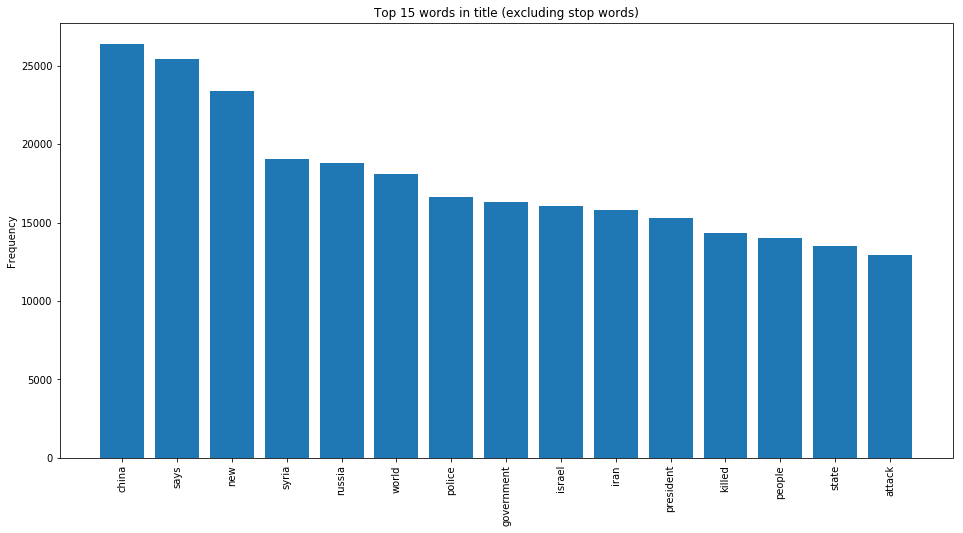

In [5]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

N = 15
titles = df['title']
top_N_words = get_top_n_words(titles.compute(), n=N)
print top_N_words

fig, ax = plt.subplots(figsize=(16, 8))
words = [x[0] for x in top_N_words]
ax.bar(range(N), [x[1] for x in top_N_words])
ax.set_xticks(range(N))
ax.set_xticklabels(words, rotation='vertical')
ax.set_title('Top 15 words in title (excluding stop words)')
ax.set_ylabel('Frequency')
plt.show()

number of titles by year


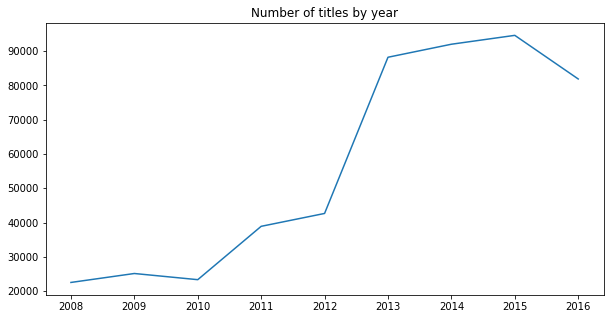

In [8]:
print "number of titles by year"
plt.figure(figsize=(10,5))
yearly_num = df['date_created'].dt.year.value_counts().compute()
    
ax = sns.lineplot(x=yearly_num.index.values,y=yearly_num.values)
ax = plt.title('Number of titles by year')

number of titles by month


Text(0.5,1,'Number of titles by month')

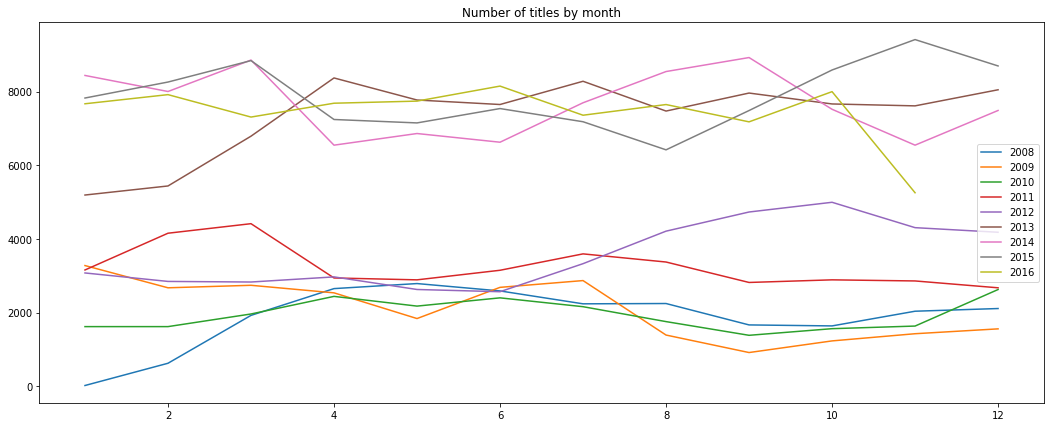

In [22]:
print "number of titles by month"
years = df['date_created'].dt.year.unique().compute()
plt.figure(figsize=(18,7))
for year in years:
    df_year = df[df['date_created'].dt.year == year]  
    monthly_nums = df_year['date_created'].dt.month.value_counts().compute()
    _ax = sns.lineplot(x=monthly_nums.index.values,y=monthly_nums.values, legend='full', label=year)

plt.title('Number of titles by month')


number of titles by day


Text(0.5,1,'Number of titles by day')

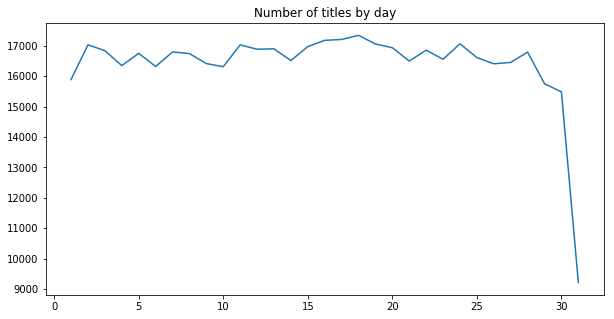

In [24]:
print "number of titles by day"
daily_num = df['date_created'].dt.day.value_counts().compute()
plt.figure(figsize=(10,5))
_ax = sns.lineplot(x=daily_num.index.values,y=daily_num.values)
plt.title('Number of titles by day')


Word Cloud


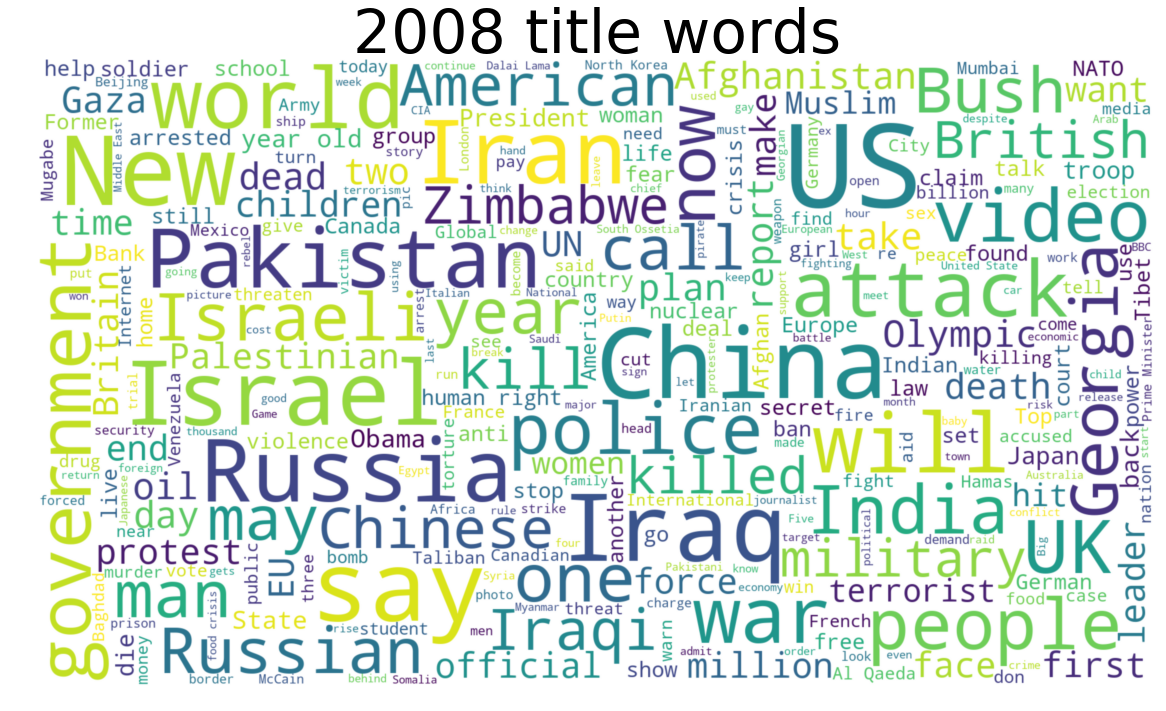

In [35]:
print "Word Cloud"
from wordcloud import WordCloud
def plot_wordcloud(words, title):
    cloud = WordCloud(width=1920, height=1080,max_font_size=200, max_words=300, background_color="white").generate(words)
    plt.figure(figsize=(20,20))
    plt.imshow(cloud, interpolation="gaussian")
    plt.axis("off") 
    plt.title(title, fontsize=60)
    plt.show()

all_text = " ".join(df[df['date_created'].dt.year == 2008].title.compute()) 
plot_wordcloud(all_text, "2008 title words")

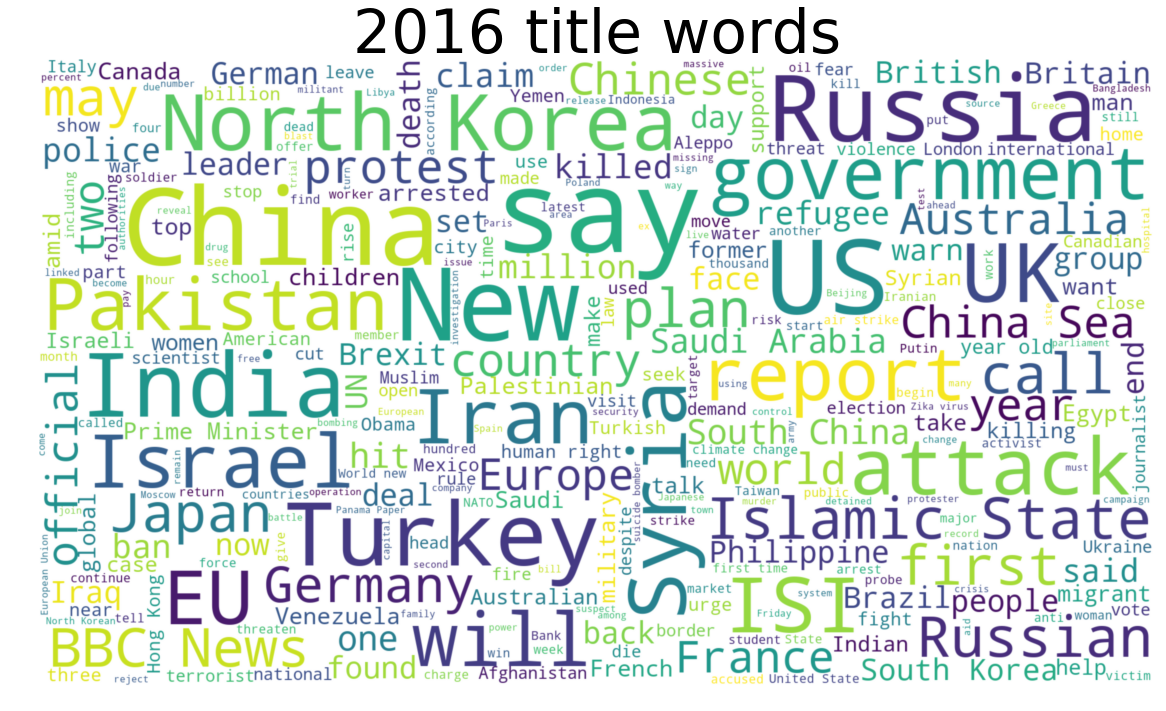

In [38]:
all_text = " ".join(df[df['date_created'].dt.year == 2016].title.compute()) 
plot_wordcloud(all_text, "2016 title words")